### Initial Setup, Get Dataset Directories

In [ ]:
import os
import numpy as np
from PIL import Image

base_dir = '/home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data' 
# Directories for the training images and their corresponding masks
mer_dir = os.path.join(base_dir, 'mer/')
msl_dir = os.path.join(base_dir, 'msl/')

# Directories for the testing images and their corresponding masks
mer_train_img_dir = os.path.join(mer_dir, 'images/train')
mer_test_img_dir = os.path.join(mer_dir, 'images/test')
mer_train_mask_dir = os.path.join(mer_dir, 'labels/train/merged-unmasked')
mer_test_mask_dir = os.path.join(mer_dir, 'labels/test/masked-gold-min1-100agree')

msl_img_dir = os.path.join(msl_dir, 'ncam/images/edr')
msl_train_mask_dir = os.path.join(msl_dir, 'ncam/labels/train')
msl_test_mask_dir = os.path.join(msl_dir, 'ncam/labels/test/masked-gold-min1-100agree')

print(f"MER Training Images Directory: {mer_train_img_dir}")
print(f"MER Testing Images Directory {mer_test_img_dir}")
print(f"MER Training Mask Directory {mer_train_mask_dir}")
print(f"MER Testing Mask Directory {mer_test_mask_dir }")
print()
print(f"MSL Images Directory: {msl_img_dir}")
print(f"MSL Training Mask Directory {msl_train_mask_dir}")
print(f"MSL Testing Mask Directory {msl_test_mask_dir }")

MER Training Images Directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/train
MER Testing Images Directory /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/test
MER Training Mask Directory /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/train/merged-unmasked
MER Testing Mask Directory /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/test/masked-gold-min1-100agree

MSL Images Directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/msl/ncam/images/edr
MSL Training Mask Directory /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/msl/ncam/labels/train
MSL Testing Mask Directory /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/msl/ncam/labels/test/masked-gold-min1-100agree


### Functions

In [ ]:
import os
import re
from typing import List, Tuple

ALLOWED_EXTENSIONS = ('.jpg', '.png', '.jpeg')

def get_base_name(filename: str) -> str:
    base = os.path.splitext(filename)[0]
    suffix_pattern = r'(_\d{5}_T\d_merged|_merged\d*|_mer)$'
    base = re.sub(suffix_pattern, '', base, flags=re.IGNORECASE)
    
    return base

def get_matched_pairs(img_dir: str, mask_dir: str) -> List[Tuple[str, str]]:

    print(f"\n[Matching] Checking image directory: {img_dir}")
    print(f"[Matching] Checking mask directory: {mask_dir}")
    
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        print("Error: One or both directories do not exist.")
        return []

    image_files = sorted([f for f in os.listdir(img_dir) 
                          if f.lower().endswith(ALLOWED_EXTENSIONS)])
    mask_candidates = [f for f in os.listdir(mask_dir) 
                       if f.lower().endswith(ALLOWED_EXTENSIONS)]
    
    print(f"[Matching] Found {len(image_files)} potential images.")
    print(f"[Matching] Found {len(mask_candidates)} mask candidates.")

    mask_map = {}
    for mask_file in mask_candidates:
        base_name = get_base_name(mask_file)
        mask_map[base_name] = os.path.join(mask_dir, mask_file)
            
    # Find Matches
    matched_pairs = []
    unmatched_images = []
    
    for img_filename in image_files:
        img_base_name = get_base_name(img_filename)
        
        if img_base_name in mask_map:
            img_path = os.path.join(img_dir, img_filename)
            mask_path = mask_map[img_base_name]
            matched_pairs.append((img_path, mask_path))
        else:
            unmatched_images.append(img_filename)

    print(f"[Matching] Successfully identified {len(matched_pairs)} image/mask pairs.")
    if unmatched_images:
        print(f"[Matching] Warning: {len(unmatched_images)} images had NO matching mask.")
        if unmatched_images:
            ex_img_name = unmatched_images[0]
            ex_img_base = get_base_name(ex_img_name)
            print(f"DEBUG: Example unmatched image '{ex_img_name}' resulted in base name '{ex_img_base}'.")
    
    return matched_pairs

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# CONSTANTS
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
TARGET_SIZE = (224, 224)

NUM_RISK_CLASSES = 3
RISK_CLASS = {
    'low': 0,       # Class 0: Mostly safe terrain
    'medium': 1,    # Class 1: Moderate risk features
    'high': 2       # Class 2: High density of dangerous features
}
NUM_TERRAIN_CLASSES = 5 
RAW_TO_INDEX = {0: 0, 1: 1, 2: 2, 3: 3, 255: 4}
MASK_MAPPING = {
    0: 'soil',
    1: 'bedrock',
    2: 'sand',
    3: 'big_rock',
    255: 'null'
}

ALLOWED_EXTENSIONS = ('.png', '.jpg', '.jpeg')

def calculate_risk_class(mask_labels):

    sand_count = mask_labels.get('sand', 0)
    rock_count = mask_labels.get('big_rock', 0)
    soil_count = mask_labels.get('soil', 0)
    bedrock_count = mask_labels.get('bedrock', 0)
    
    total = sand_count + rock_count + soil_count + bedrock_count
    
    if total == 0:
        return 1  # Default to Medium Risk for unknown terrain
    
    # Calculate percentages
    sand_pct = sand_count / total
    rock_pct = rock_count / total
    soil_pct = soil_count / total
    bedrock_pct = bedrock_count / total
    
    # HIGH RISK
    if sand_pct > 0.40 or rock_pct > 0.35 or (sand_pct + rock_pct) > 0.50:
        return 2
    
    # LOW RISK
    if (soil_pct > 0.65 and 
        sand_pct < 0.10 and 
        rock_pct < 0.15):
        return 0
    
    # MEDIUM RISK
    return 1
    
def _parse_mask_for_risk(mask_path_tensor, n_classes=NUM_RISK_CLASSES):
    
    mask_bytes = tf.io.read_file(mask_path_tensor)
    mask = tf.image.decode_png(mask_bytes, channels=1)
    mask = tf.image.resize(mask, TARGET_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(tf.squeeze(mask), dtype=tf.uint8) 

    def py_calculate_risk(mask_np):
        pixel_counts = {}
        for raw_value, terrain_name in MASK_MAPPING.items():
            if terrain_name == 'null': continue 
            count = np.sum(mask_np == raw_value)
            pixel_counts[terrain_name] = count
        
        risk_class = calculate_risk_class(pixel_counts)
        return to_categorical(risk_class, num_classes=n_classes)
        
    risk_label = tf.numpy_function(
        func=py_calculate_risk,
        inp=[mask],
        Tout=tf.float32,
        name='calculate_risk_label'
    )
    risk_label.set_shape([n_classes]) 
    return risk_label

def create_tf_dataset(img_dir, mask_dir, batch_size=32, target_size=(224, 224), 
                      n_classes=3, test_size=0.1, random_state=42):
    """
    Creates the GPU-accelerated tf.data.Dataset pipelines for training, validation,
    and testing by loading only file paths into memory, solving the crash issue.
    
    Returns: train_ds, val_ds, test_ds, total_train_samples
    """
    
    full_train_pairs = get_matched_pairs(img_dir, mask_dir)
    
    if not full_train_pairs:
        raise ValueError("No matched pairs found for training data.")

    train_paths, val_paths = train_test_split(
        full_train_pairs, 
        test_size=test_size, 
        random_state=random_state
    )

    def _parse_mask_for_risk(mask_path_tensor):
        
        mask_bytes = tf.io.read_file(mask_path_tensor)
        mask = tf.image.decode_png(mask_bytes, channels=1)
        mask = tf.image.resize(mask, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask = tf.cast(tf.squeeze(mask), dtype=tf.uint8) 

        def py_calculate_risk(mask_np):
            pixel_counts = {}
            # NOTE: MASK_MAPPING must be available here
            for raw_value, terrain_name in MASK_MAPPING.items():
                 # Handle case where value is 255 (null)
                if terrain_name == 'null': continue 
                count = np.sum(mask_np == raw_value)
                pixel_counts[terrain_name] = count
            
            risk_class = calculate_risk_class(pixel_counts)
            return to_categorical(risk_class, num_classes=n_classes)
            
        risk_label = tf.numpy_function(
            func=py_calculate_risk,
            inp=[mask],
            Tout=tf.float32,
            name='calculate_risk_label'
        )
        risk_label.set_shape([n_classes])
        return risk_label
    
    def load_and_preprocess_image(img_path_tensor, risk_label_tensor):
        img_bytes = tf.io.read_file(img_path_tensor)
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.resize(img, target_size, method=tf.image.ResizeMethod.BILINEAR)
        img = tf.cast(img, tf.float32)
        return img, risk_label_tensor

    def build_pipeline(pairs, shuffle=True):
        img_paths = [pair[0] for pair in pairs]
        mask_paths = [pair[1] for pair in pairs]
        
        path_ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
        
        # Calculate Risk Label
        risk_ds = path_ds.map(
            lambda img_p, mask_p: (img_p, _parse_mask_for_risk(mask_p)),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        # Load and Preprocess Image
        final_ds = risk_ds.map(
            load_and_preprocess_image,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        if shuffle:
            final_ds = final_ds.shuffle(buffer_size=1000)
            
        return final_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE), len(pairs)

    # Build all pipelines
    train_ds, total_train = build_pipeline(train_paths, shuffle=True)
    val_ds, total_val = build_pipeline(val_paths, shuffle=False)
    
    # Return everything needed for model.fit()
    return train_ds, val_ds, total_train, total_val

def load_and_preprocess_image(img_path_tensor, risk_label_tensor):
    """
    TensorFlow function to load, decode, resize, and normalize the image.
    This runs efficiently as part of the tf.data pipeline.
    """
    # Load and decode image 
    img_bytes = tf.io.read_file(img_path_tensor)
    
    img = tf.image.decode_jpeg(img_bytes, channels=3) 
    
    # Resize image 
    img = tf.image.resize(img, TARGET_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32)
    
    return img, risk_label_tensor

def create_single_tf_dataset(img_dir, mask_dir, batch_size, target_size):

    # Get the list of matched file paths
    pairs = get_matched_pairs(img_dir, mask_dir)
    total_samples = len(pairs)
    
    if not pairs:
        print(f"Warning: No matched pairs found in {img_dir}. Returning empty dataset.")
        return tf.data.Dataset.from_tensors((tf.constant(0.0), tf.constant(0.0))).batch(1), 0

    img_paths = [pair[0] for pair in pairs]
    mask_paths = [pair[1] for pair in pairs]
    
    path_ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    
    # Calculate Risk Label

    risk_ds = path_ds.map(
        lambda img_p, mask_p: (img_p, _parse_mask_for_risk(mask_p)),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Load and Preprocess Image
    final_ds = risk_ds.map(
        load_and_preprocess_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    final_ds = final_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return final_ds, total_samples

In [ ]:
def create_datasets_with_expert_test_separation(
    all_img_dirs,
    all_mask_dirs,
    expert_test_mask_dirs,
    mer_test_img_dir=None,
    batch_size=32,
    target_size=(224, 224),
    val_size=0.15,
    random_state=42
):
    """
    Separates expert test data from MER and MSL, combines rest for training.
    """
    
    # Build lookup of ALL expert test mask base names
    print("\n=== Loading Expert Test Masks ===")
    all_test_base_lookup = {}
    
    for i, test_mask_dir in enumerate(expert_test_mask_dirs):
        source = "MER" if i == 0 else "MSL"
        print(f"\n{source} test masks: {test_mask_dir}")
        
        test_mask_files = [f for f in os.listdir(test_mask_dir) 
                           if f.lower().endswith(ALLOWED_EXTENSIONS)]
        
        for mask_file in test_mask_files:
            base = get_base_name(mask_file)
            mask_path = os.path.join(test_mask_dir, mask_file)
            all_test_base_lookup[base] = (mask_path, source)
        
        print(f"  Found {len(test_mask_files)} expert test masks")
    
    print(f"\nTotal unique expert test base names: {len(all_test_base_lookup)}")
    
    #  Handle MER test images
    test_pairs = []
    
    if mer_test_img_dir:
        print("\n=== Processing MER Test Images ===")
        print(f"MER test image directory: {mer_test_img_dir}")
        
        mer_test_img_files = [f for f in os.listdir(mer_test_img_dir) 
                              if f.lower().endswith(ALLOWED_EXTENSIONS)]
        
        mer_test_matched = 0
        for img_file in mer_test_img_files:
            img_base = get_base_name(img_file)
            
            if img_base in all_test_base_lookup:
                img_path = os.path.join(mer_test_img_dir, img_file)
                mask_path, source = all_test_base_lookup[img_base]
                test_pairs.append((img_path, mask_path))
                mer_test_matched += 1
        
        print(f"  Matched {mer_test_matched} MER test images with expert masks")
    
    #  Scan all image directories for test image
    print("\n=== Finding MSL Test Images ===")
    
    test_img_bases_found = set()  # Track which test images we've found
    
    for idx, img_dir in enumerate(all_img_dirs):
        is_mer = (idx == 0)
        source_name = "MER" if is_mer else "MSL"
        
        if is_mer and mer_test_img_dir:
            continue
        
        print(f"\n{source_name} - Scanning for test images: {img_dir}")
        
        img_files = [f for f in os.listdir(img_dir) 
                     if f.lower().endswith(ALLOWED_EXTENSIONS)]
        
        test_count = 0
        for img_file in img_files:
            img_base = get_base_name(img_file)
            
            if img_base in all_test_base_lookup:
                img_path = os.path.join(img_dir, img_file)
                mask_path, mask_source = all_test_base_lookup[img_base]
                test_pairs.append((img_path, mask_path))
                test_img_bases_found.add(img_base)
                test_count += 1
        
        print(f"  Found {test_count} test images")

    print("\nCollecting Training Data")
    train_pairs = []
    
    for idx, (img_dir, mask_dir) in enumerate(zip(all_img_dirs, all_mask_dirs)):
        is_mer = (idx == 0)
        source_name = "MER" if is_mer else "MSL"
        
        print(f"\n{source_name} - Scanning: {img_dir}")
        all_pairs = get_matched_pairs(img_dir, mask_dir)
        print(f"  Found {len(all_pairs)} total pairs")
        
        train_count = 0
        excluded_count = 0
        
        for img_path, regular_mask_path in all_pairs:
            img_base = get_base_name(os.path.basename(img_path))
            
            # Exclude if this image is in the test set
            if img_base in test_img_bases_found:
                excluded_count += 1
                continue
            
            # Add to training
            train_pairs.append((img_path, regular_mask_path))
            train_count += 1
        
        print(f"  → Training:    {train_count}")
        print(f"  → Excluded (in test set): {excluded_count}")
    
    # Validate
    print(f"\n=== Separation Summary ===")
    print(f"Expert test pairs: {len(test_pairs)}")
    print(f"Training pairs:    {len(train_pairs)}")
    
    if len(test_pairs) == 0:
        raise ValueError("ERROR: No test pairs found!")
    
    if len(train_pairs) == 0:
        raise ValueError("ERROR: No training pairs found!")
    
    # Split training into train/val
    train_only, val_only = train_test_split(
        train_pairs,
        test_size=val_size,
        random_state=random_state
    )
    
    total = len(train_only) + len(val_only) + len(test_pairs)
    print(f"\n=== Final Split ===")
    print(f"  Train: {len(train_only):4d} ({len(train_only)/total*100:.1f}%)")
    print(f"  Val:   {len(val_only):4d} ({len(val_only)/total*100:.1f}%)")
    print(f"  Test:  {len(test_pairs):4d} ({len(test_pairs)/total*100:.1f}%) [EXPERT: MER+MSL]")
    
    # Create TF datasets
    def build_pipeline(pairs, shuffle=True):
        img_paths = [p[0] for p in pairs]
        mask_paths = [p[1] for p in pairs]
        
        path_ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
        
        risk_ds = path_ds.map(
            lambda img_p, mask_p: (img_p, _parse_mask_for_risk(mask_p)),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        final_ds = risk_ds.map(
            load_and_preprocess_image,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        if shuffle:
            final_ds = final_ds.shuffle(buffer_size=1000)
            
        return final_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    train_ds = build_pipeline(train_only, shuffle=True)
    val_ds = build_pipeline(val_only, shuffle=False)
    test_ds = build_pipeline(test_pairs, shuffle=False)
    
    return train_ds, val_ds, test_ds, {
        'train': len(train_only),
        'val': len(val_only),
        'test': len(test_pairs)
    }

In [7]:
# All image directories (MER has separate train/test, MSL has all mixed)
all_img_dirs = [
    mer_train_img_dir,    # MER training images only
    msl_img_dir           # MSL all images (train + test mixed)
]

# All training mask directories
all_mask_dirs = [
    mer_train_mask_dir,   # MER training masks
    msl_train_mask_dir    # MSL training masks
]

# All expert test mask directories
expert_test_mask_dirs = [
    mer_test_mask_dir,    # MER expert test masks
    msl_test_mask_dir     # MSL expert test masks
]

# Create datasets
train_ds, val_ds, test_ds, counts = create_datasets_with_expert_test_separation(
    all_img_dirs=all_img_dirs,
    all_mask_dirs=all_mask_dirs,
    expert_test_mask_dirs=expert_test_mask_dirs,
    mer_test_img_dir=mer_test_img_dir,  # MER's separate test image directory
    batch_size=32,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    val_size=0.15,
    random_state=42
)

print(f"\n--- Final Dataset Summary ---")
print(f"Training samples:   {counts['train']}")
print(f"Validation samples: {counts['val']}")
print(f"Test samples:       {counts['test']} (MER + MSL expert-labeled)")


=== STEP 1: Loading Expert Test Masks ===

MER test masks: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/test/masked-gold-min1-100agree
  Found 204 expert test masks

MSL test masks: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/msl/ncam/labels/test/masked-gold-min1-100agree
  Found 322 expert test masks

Total unique expert test base names: 526

=== STEP 2a: Processing MER Test Images ===
MER test image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/test
  Matched 204 MER test images with expert masks

=== STEP 2b: Finding MSL Test Images ===

MSL - Scanning for test images: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/msl/ncam/images/edr
  Found 322 test images

=== STEP 3: Collecting Training Data ===

MER - Scanning: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/train

[Matching] Checking image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/dat

In [ ]:
def verify_dataset_sample(img_dir: str, mask_dir: str, num_samples: int = 5):
    """
    Verifies the entire data pipeline (image loading, mask loading, and risk calculation)
    by sampling from the raw file paths and displaying the results.
    
    """
    print(f"\n--- Running Verification on {os.path.basename(img_dir)} data ---")
    
    all_pairs = get_matched_pairs(img_dir, mask_dir)
    if not all_pairs:
        print("No matched pairs found for verification.")
        return

    # Select random samples for display
    indices = np.random.choice(len(all_pairs), min(num_samples, len(all_pairs)), replace=False)
    
    # Setup plot
    fig, axes = plt.subplots(len(indices), 3, figsize=(15, 5 * len(indices)))
    if len(indices) == 1:
        axes = np.array([axes]) # Ensure axes is 2D for consistent indexing

    RISK_MAPPING = {0: 'Low Risk', 1: 'Medium Risk', 2: 'High Risk'}

    for row, i in enumerate(indices):
        img_path, mask_path = all_pairs[i]
        
        # --- Load and Process Image (for display) ---
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)
        img_normalized = img_resized.astype(np.float32) / 255.0

        # --- Load and Process Mask (for display and calculation) ---
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_resized = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        
        # --- Calculate Risk Label ---
        pixel_counts = {}
        for raw_value, terrain_name in MASK_MAPPING.items():
            if terrain_name == 'null': continue 
            count = np.sum(mask_resized == raw_value)
            pixel_counts[terrain_name] = count
            
        risk_index = calculate_risk_class(pixel_counts)
        risk_label = RISK_MAPPING.get(risk_index, "Unknown")

        # Raw Image
        ax_img = axes[row, 0]
        ax_img.imshow(img_resized) 
        ax_img.set_title(f"Image ({img_resized.shape})", fontsize=10)
        ax_img.axis('off')

        # Resized Mask
        ax_mask = axes[row, 1]
        # Use a colormap that highlights different pixel values (terrains)
        ax_mask.imshow(mask_resized, cmap='gist_ncar', vmin=0, vmax=NUM_TERRAIN_CLASSES - 1) 
        ax_mask.set_title(f"Mask ({mask_resized.shape})", fontsize=10)
        ax_mask.axis('off')

        # Risk Summary
        ax_summary = axes[row, 2]
        ax_summary.text(0.1, 0.8, f"Calculated Risk:", fontsize=12, fontweight='bold')
        ax_summary.text(0.1, 0.65, f"{risk_label} ({risk_index})", 
                        color='green' if risk_index == 0 else ('orange' if risk_index == 1 else 'red'), 
                        fontsize=14, fontweight='bold')
        
        # Display pixel counts
        y_pos = 0.5
        ax_summary.text(0.1, y_pos, "Terrain Counts:", fontsize=10)
        for name, count in pixel_counts.items():
             y_pos -= 0.1
             ax_summary.text(0.15, y_pos, f"- {name}: {count}", fontsize=9)

        ax_summary.set_xlim(0, 1)
        ax_summary.set_ylim(0, 1)
        ax_summary.axis('off')


    plt.tight_layout()
    plt.show()
    print("--- Verification Complete ---")


--- Running Verification on train data ---

[Matching] Checking image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/train
[Matching] Checking mask directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/train/merged-unmasked
[Matching] Found 16300 potential images.
[Matching] Found 8507 mask candidates.
[Matching] Successfully identified 8303 image/mask pairs.
[Matching] Warning: 7997 images had NO matching mask.
DEBUG: Example unmatched image '1n128624123eff0205p1540l0m1.JPG' resulted in base name '1n128624123eff0205p1540l0m1'.


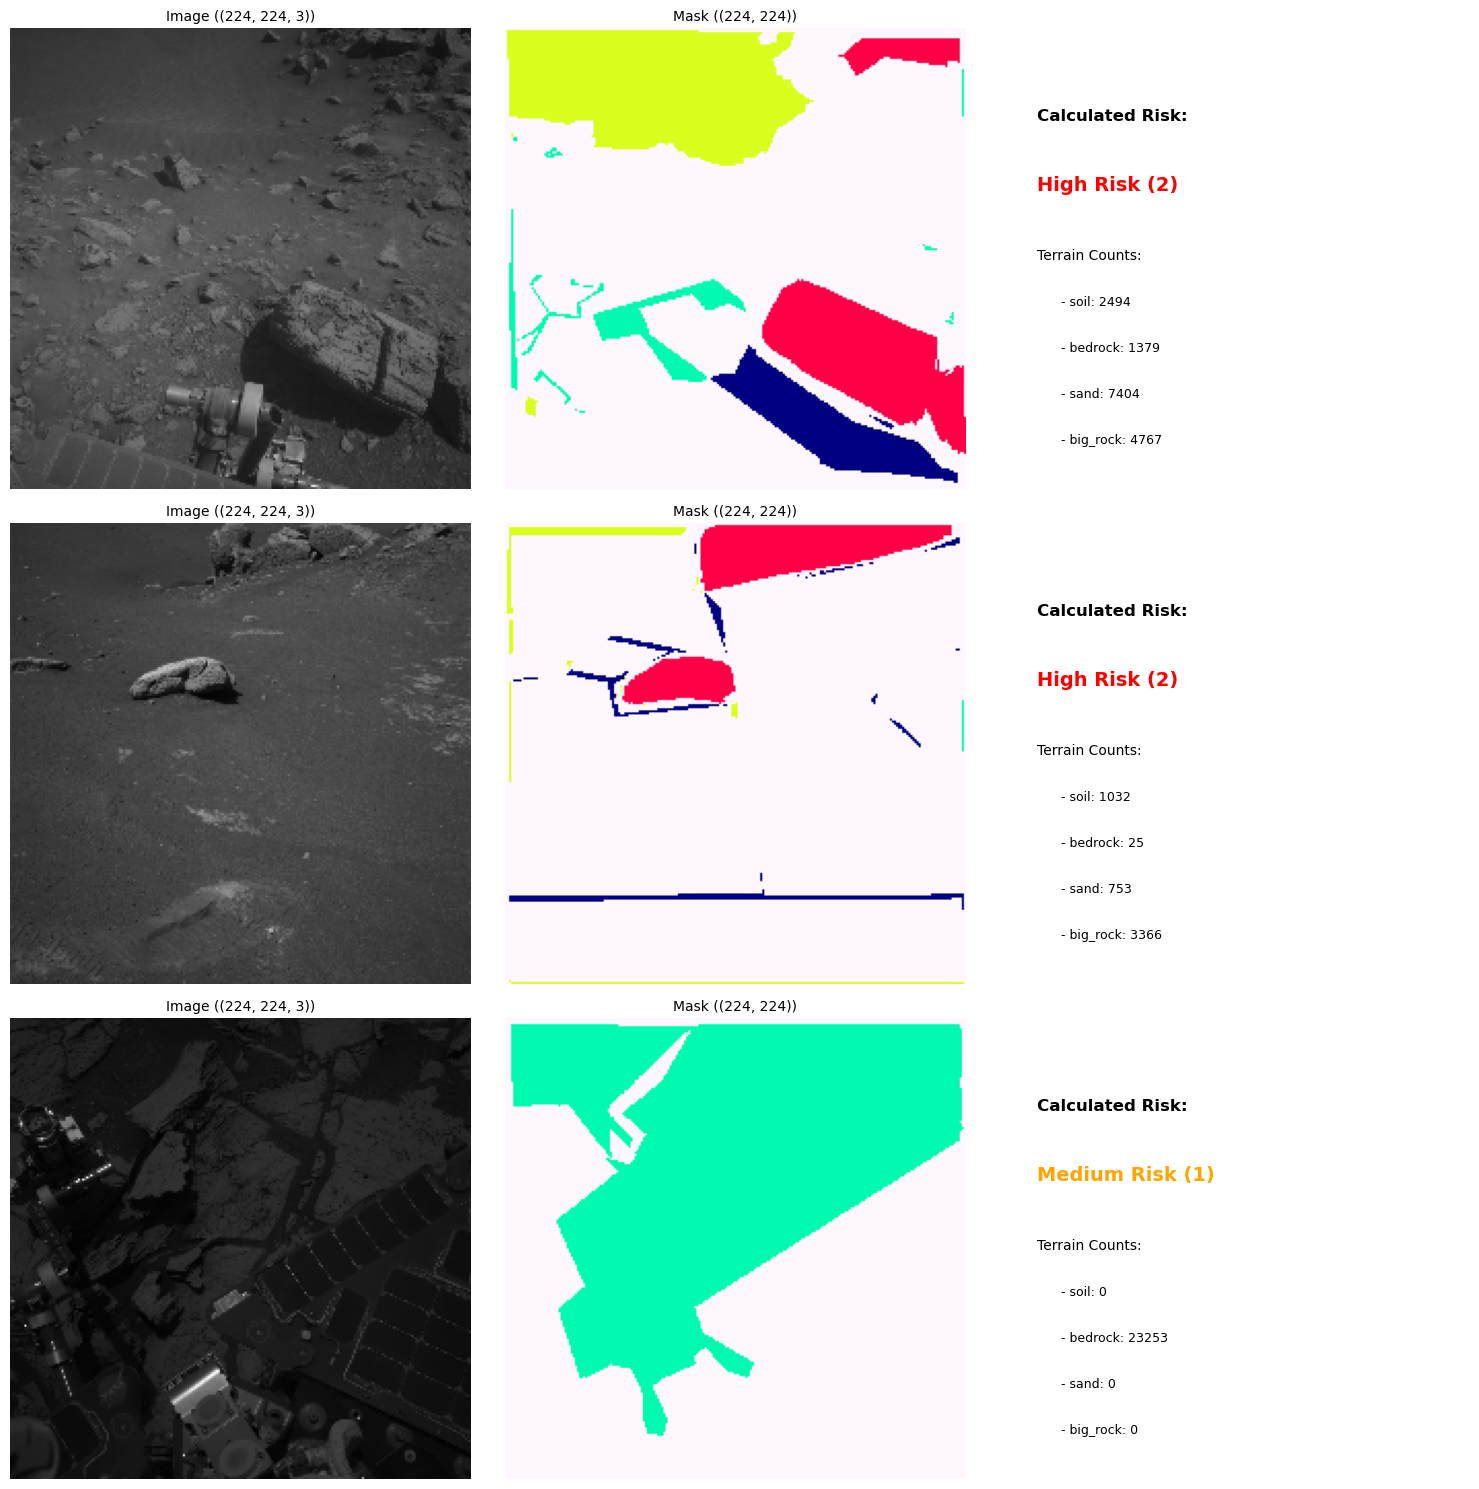

--- Verification Complete ---

--- Running Verification on test data ---

[Matching] Checking image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/test
[Matching] Checking mask directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/test/masked-gold-min1-100agree
[Matching] Found 204 potential images.
[Matching] Found 204 mask candidates.
[Matching] Successfully identified 204 image/mask pairs.


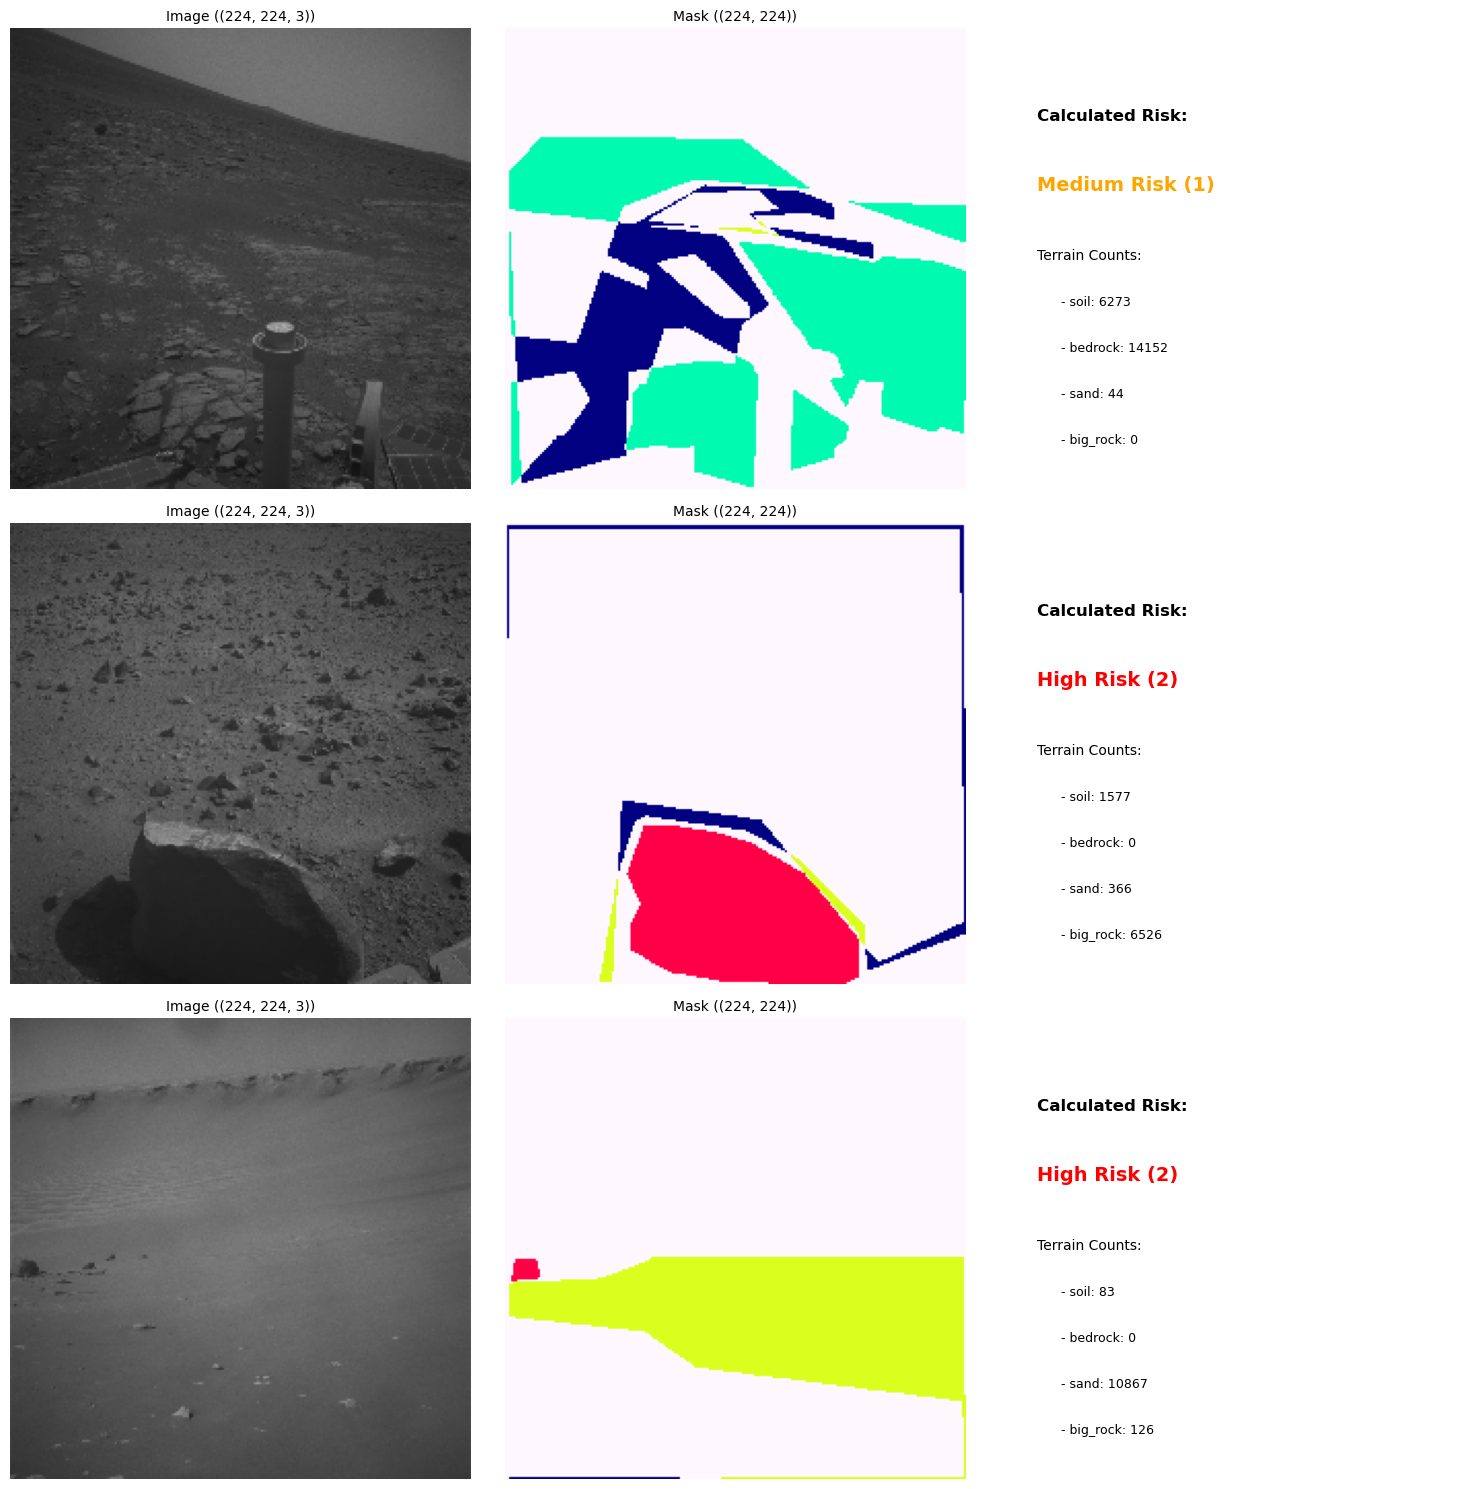

--- Verification Complete ---

--- Running Verification on edr data ---

[Matching] Checking image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/msl/ncam/images/edr
[Matching] Checking mask directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/msl/ncam/labels/train
[Matching] Found 18127 potential images.
[Matching] Found 16064 mask candidates.
[Matching] Successfully identified 16064 image/mask pairs.
[Matching] Warning: 2063 images had NO matching mask.
DEBUG: Example unmatched image 'NLA_397586928EDR_F0010008AUT_04096M1.JPG' resulted in base name 'NLA_397586928EDR_F0010008AUT_04096M1'.


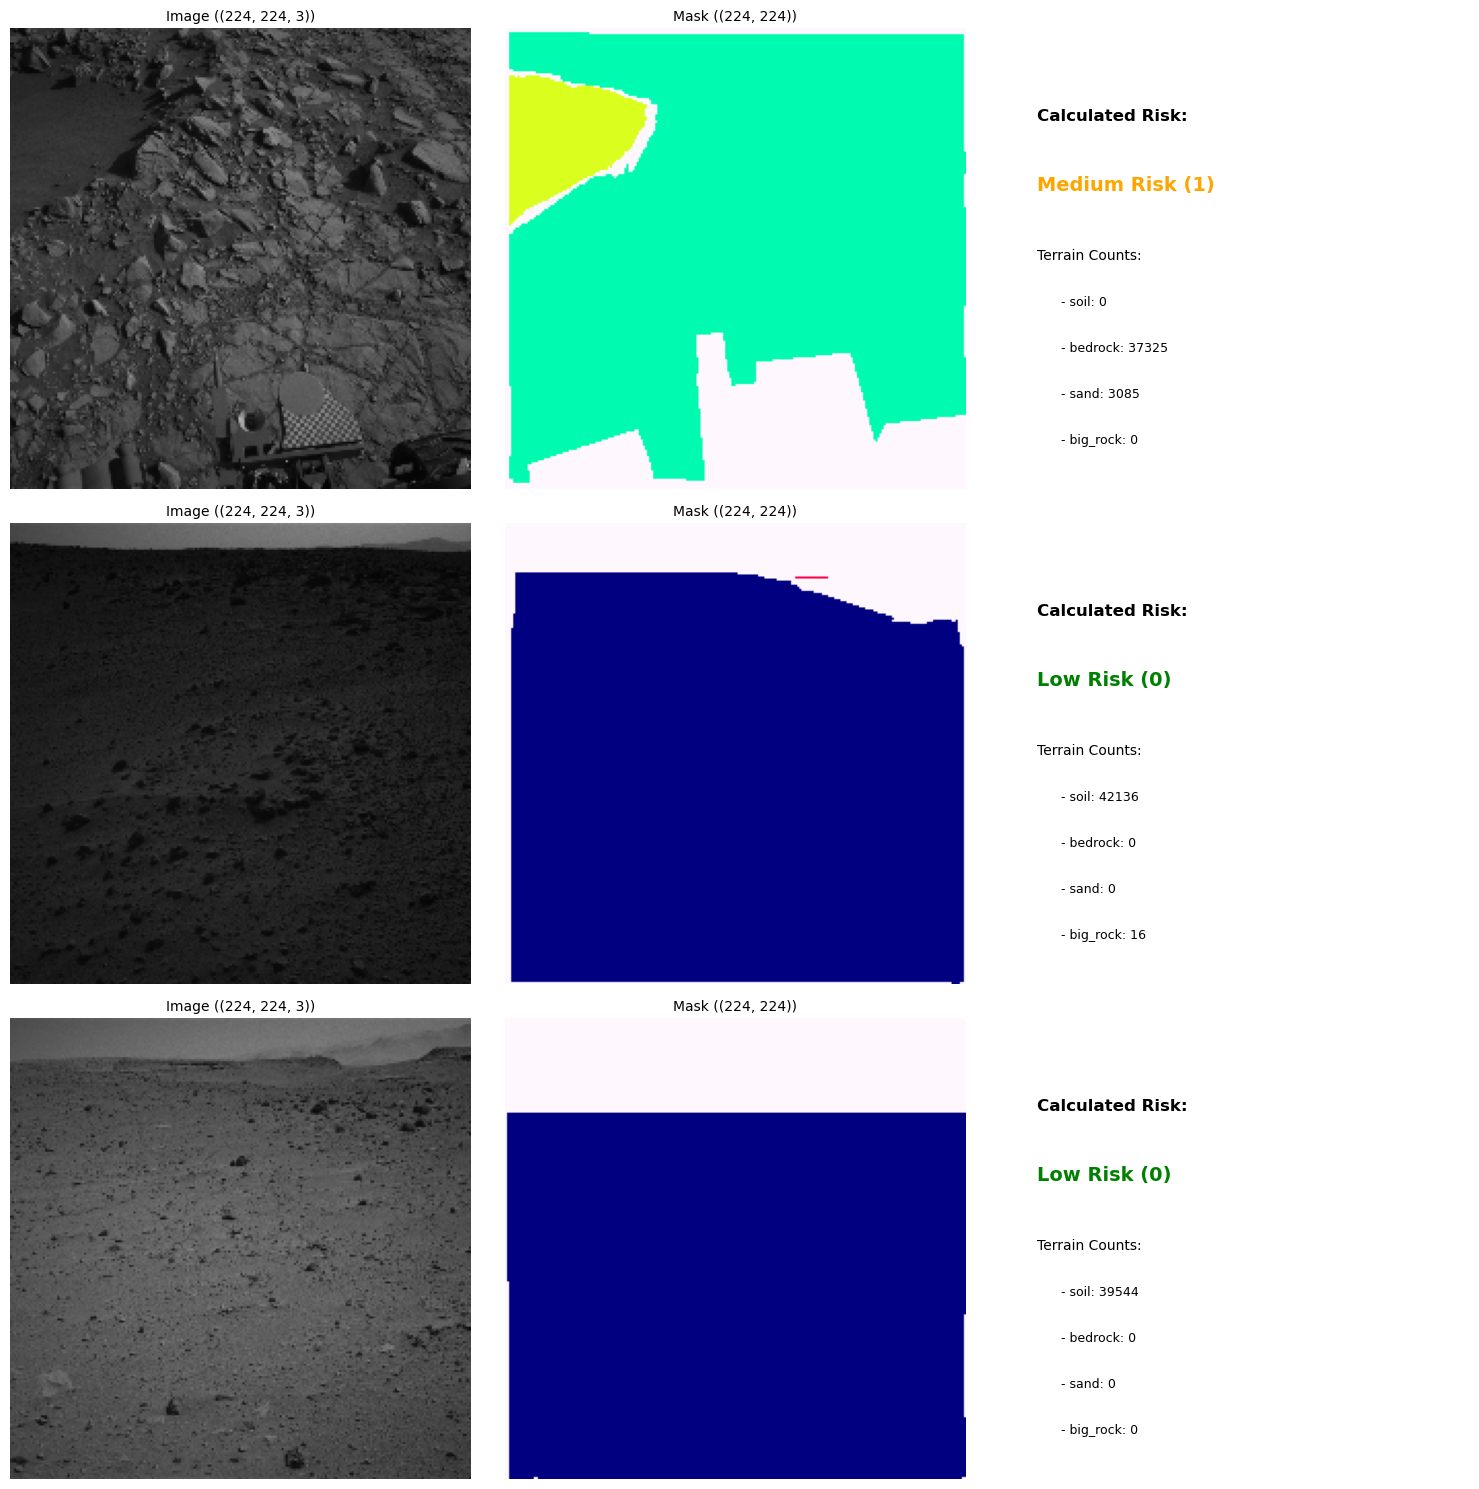

--- Verification Complete ---


In [33]:

# Verify MER training data
verify_dataset_sample(
    img_dir=mer_train_img_dir,
    mask_dir=mer_train_mask_dir,
    num_samples=3
)

# Verify MER test data (expert labels)
verify_dataset_sample(
    img_dir=mer_test_img_dir,
    mask_dir=mer_test_mask_dir,
    num_samples=3
)

# Verify MSL data
verify_dataset_sample(
    img_dir=msl_img_dir,
    mask_dir=msl_train_mask_dir,  # Use train masks for general verification
    num_samples=3
)

### Define Custom CNN model

In [ ]:
from tensorflow.keras import layers, models, optimizers

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

model = models.Sequential([
        
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

       
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

      
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.GlobalAveragePooling2D(), 

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        
        # Final output layer 
        layers.Dense(NUM_RISK_CLASSES, activation='softmax') 
    ])

### Compile CNN Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 32

# Calculate steps per epoch
steps_per_epoch = int(np.ceil(counts['train'] / batch_size))
validation_steps = int(np.ceil(counts['val'] / batch_size))

model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

model.summary()

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    # Save the best model weights
    ModelCheckpoint('basic-cnn.h5', monitor='val_accuracy', save_best_only=True)
]

Model: "sequential"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
          

In [37]:
epochs = 50

history = model.fit(
        train_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

Epoch 1/50


2025-11-23 18:30:05.900568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-11-23 18:30:07.737018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-11-23 18:30:09.691113: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3ef895ad00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-23 18:30:09.691163: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-11-23 18:30:09.710905: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-23 18:30:09.841193: I ./tensorflow/compiler/jit/device_compiler.

648/648 [==============================] - 89s 120ms/step - loss: 0.7412 - accuracy: 0.6715 - val_loss: 0.6456 - val_accuracy: 0.7426
Epoch 2/50


/home/ws/.local/share/mamba/envs/tf-gpu2/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


648/648 [==============================] - 79s 119ms/step - loss: 0.5736 - accuracy: 0.7634 - val_loss: 0.5451 - val_accuracy: 0.7793
Epoch 3/50
648/648 [==============================] - 80s 121ms/step - loss: 0.5143 - accuracy: 0.7912 - val_loss: 1.3017 - val_accuracy: 0.4442
Epoch 4/50
648/648 [==============================] - 79s 119ms/step - loss: 0.4736 - accuracy: 0.8082 - val_loss: 0.6493 - val_accuracy: 0.7574
Epoch 5/50
648/648 [==============================] - 81s 123ms/step - loss: 0.4571 - accuracy: 0.8156 - val_loss: 0.4449 - val_accuracy: 0.8151
Epoch 6/50
648/648 [==============================] - 81s 122ms/step - loss: 0.4404 - accuracy: 0.8213 - val_loss: 0.4761 - val_accuracy: 0.7968
Epoch 7/50
648/648 [==============================] - 81s 121ms/step - loss: 0.4228 - accuracy: 0.8265 - val_loss: 0.4345 - val_accuracy: 0.8165
Epoch 8/50
648/648 [==============================] - 82s 123ms/step - loss: 0.4125 - accuracy: 0.8296 - val_loss: 0.6155 - val_accuracy: 0.7

### Evaluate Model

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

class_names = ['low', 'medium', 'high'] 

test_steps = int(np.ceil(counts['test'] / batch_size))

model.load_weights('./basic-cnn.h5') 

raw_predictions = model.predict(test_ds, steps=test_steps)

y_true_list = []
    
 # Iterate over the dataset to get the labels
for _, labels in test_ds.take(test_steps):
# 'labels' are the one-hot encoded true labels for the current batch
    y_true_list.append(labels.numpy())
        
# Concatenate all batches of true labels into a single NumPy array
y_true_one_hot = np.concatenate(y_true_list, axis=0)

# Convert one-hot encoded vectors to single class indices (0, 1, 2)
# Apply argmax to the predictions and the collected true labels
pred_indices = np.argmax(raw_predictions, axis=1)
y_true_indices = np.argmax(y_true_one_hot, axis=1)
    
y_true_indices = y_true_indices[:counts['test']]
pred_indices = pred_indices[:counts['test']]


# Calculate and report metrics
score = accuracy_score(y_true_indices, pred_indices)
print("\n--- Results ---")
print(f"Final Test Accuracy: {score:.4f}")
    
# Classification report
report = classification_report(
    y_true_indices, 
    pred_indices, 
    target_names=class_names, 
    zero_division=0
)
print("\nClassification Report:")
print(report)

17/17 [==============================] - 1s 52ms/step

--- Results ---
Final Test Accuracy: 0.8061

Classification Report:
              precision    recall  f1-score   support

         low       0.81      0.93      0.87       211
      medium       0.75      0.77      0.76       175
        high       0.89      0.66      0.76       140

    accuracy                           0.81       526
   macro avg       0.82      0.79      0.80       526
weighted avg       0.81      0.81      0.80       526



[[196  12   3]
 [ 32 135   8]
 [ 13  34  93]]



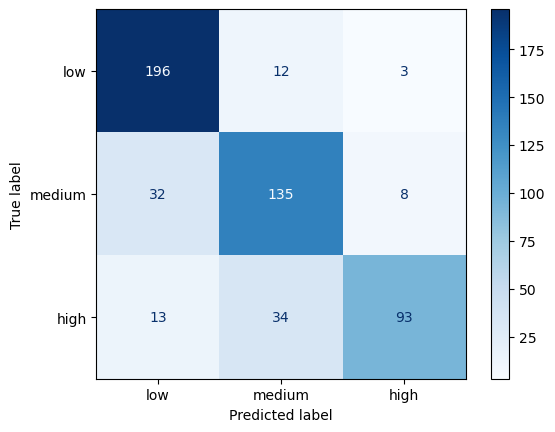

In [40]:
# Confusion matrix
cm = confusion_matrix(y_true_indices, pred_indices)
print(cm)
print()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Transfer Learning: EfficientNetB0

In [9]:
#del model
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

# Input Layer Definition
input_tensor = layers.Input(shape=input_shape)

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_tensor=input_tensor,
    input_shape=input_shape,
    pooling='avg'
)

# Freeze base model
base_model.trainable = False

# Build classification head
x = base_model.output
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.6)(x)
output = layers.Dense(NUM_RISK_CLASSES, activation='softmax')(x)

# Final model
en0_model = models.Model(inputs=input_tensor, outputs=output)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 32

# Calculate steps per epoch
steps_per_epoch = int(np.ceil(counts['train'] / batch_size))
validation_steps = int(np.ceil(counts['val'] / batch_size))

en0_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

en0_callbacks = [

    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('en0.h5', monitor='val_accuracy', save_best_only=True)
]

In [ ]:
epochs = 50

en0_history = en0_model.fit(
        train_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        callbacks=en0_callbacks
    )

Epoch 1/50


648/648 [==============================] - 53s 79ms/step - loss: 0.2699 - accuracy: 0.8865 - val_loss: 0.4189 - val_accuracy: 0.8515
Epoch 2/50
648/648 [==============================] - 55s 83ms/step - loss: 0.2685 - accuracy: 0.8901 - val_loss: 0.4219 - val_accuracy: 0.8518
Epoch 3/50
648/648 [==============================] - 55s 81ms/step - loss: 0.2560 - accuracy: 0.8940 - val_loss: 0.4399 - val_accuracy: 0.8512
Epoch 4/50
284/648 [============>.................] - ETA: 19:04 - loss: 0.2590 - accuracy: 0.8894

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

en0_model.load_weights('en0.h5') 

test_steps = int(np.ceil(counts['test'] / batch_size))

class_names = ['low', 'medium', 'high'] 

en0_raw = en0_model.predict(test_ds, steps=test_steps)

y_true_list = []
    
for _, labels in test_ds.take(test_steps):
    y_true_list.append(labels.numpy())
        
y_true_one_hot = np.concatenate(y_true_list, axis=0)

pred_indices = np.argmax(en0_raw, axis=1)
y_true_indices = np.argmax(y_true_one_hot, axis=1)
    
y_true_indices = y_true_indices[:counts['test']]
pred_indices = pred_indices[:counts['test']]

en0_score = accuracy_score(y_true_indices, pred_indices)
print("\n--- Results ---")
print(f"Final Test Accuracy: {en0_score:.4f}")
    
# Classification report
report = classification_report(
    y_true_indices, 
    pred_indices, 
    target_names=class_names, 
    zero_division=0
)
print("\nClassification Report:")
print(report)

2025-11-23 21:18:05.664340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907


17/17 [==============================] - 4s 49ms/step

--- Results ---
Final Test Accuracy: 0.8213

Classification Report:
              precision    recall  f1-score   support

         low       0.83      0.86      0.85       211
      medium       0.76      0.85      0.80       175
        high       0.90      0.73      0.81       140

    accuracy                           0.82       526
   macro avg       0.83      0.81      0.82       526
weighted avg       0.83      0.82      0.82       526



In [ ]:
from tensorflow.keras.models import load_model

tf.keras.backend.clear_session()

def get_backbone_layers(model):
    """Returns a list of all layers belonging to the EfficientNet backbone."""
    backbone_layers = []
    # Iterate through all layers in the loaded model
    for layer in model.layers:
        # The base model output ends just before the global pooling layer.
        if layer.name.startswith('avg_pool') or layer.name.startswith('dense'):
            break # Stop when we hit the new classification head
        backbone_layers.append(layer)
    return backbone_layers

en0_model = load_model('en0.h5', compile=False)

backbone_layers = get_backbone_layers(en0_model)

for layer in backbone_layers:
    layer.trainable = True

NUM_FROZEN_LAYERS = 100 

for layer in backbone_layers[:NUM_FROZEN_LAYERS]:
    layer.trainable = False

trainable_count = sum(1 for layer in backbone_layers if layer.trainable)
print(f"Number of layers now trainable in EfficientNetB0: {trainable_count}")


# Recompile the model with a lower Learning Rate
PHASE_2_LR = 1e-5

en0_model.compile(
    optimizer=optimizers.Adam(learning_rate=PHASE_2_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel Re-compiled successfully with new Learning Rate: {PHASE_2_LR}")
print("Starting Fine-Tuning (Phase 2)...")

en0_callbacks_p2 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('en0_finetuned.h5', monitor='val_accuracy', save_best_only=True)
]

Number of layers now trainable in EfficientNetB0: 138

Model Re-compiled successfully with new Learning Rate: 1e-05
Starting Fine-Tuning (Phase 2)...


In [22]:
en0_history_p2 = en0_model.fit(
    train_ds,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=en0_callbacks_p2
)

Epoch 1/100
648/648 [==============================] - 76s 115ms/step - loss: 0.2164 - accuracy: 0.9109 - val_loss: 0.4226 - val_accuracy: 0.8597
Epoch 2/100
648/648 [==============================] - 82s 124ms/step - loss: 0.2064 - accuracy: 0.9139 - val_loss: 0.4214 - val_accuracy: 0.8611
Epoch 3/100
648/648 [==============================] - 78s 117ms/step - loss: 0.1993 - accuracy: 0.9183 - val_loss: 0.4282 - val_accuracy: 0.8586
Epoch 4/100
648/648 [==============================] - 79s 119ms/step - loss: 0.1946 - accuracy: 0.9215 - val_loss: 0.4350 - val_accuracy: 0.8611
Epoch 5/100
648/648 [==============================] - 79s 119ms/step - loss: 0.1846 - accuracy: 0.9259 - val_loss: 0.4457 - val_accuracy: 0.8597
Epoch 6/100
648/648 [==============================] - 79s 119ms/step - loss: 0.1786 - accuracy: 0.9287 - val_loss: 0.4489 - val_accuracy: 0.8616
Epoch 7/100
648/648 [==============================] - 77s 116ms/step - loss: 0.1763 - accuracy: 0.9290 - val_loss: 0.4599 -

In [ ]:

en0_model.load_weights('en0_finetuned.h5') 

en0_raw = en0_model.predict(test_ds, steps=test_steps)

y_true_list = []
    
for _, labels in test_ds.take(test_steps):
    y_true_list.append(labels.numpy())
        
y_true_one_hot = np.concatenate(y_true_list, axis=0)

pred_indices = np.argmax(en0_raw, axis=1)
y_true_indices = np.argmax(y_true_one_hot, axis=1)

y_true_indices = y_true_indices[:counts['test']]
pred_indices = pred_indices[:counts['test']]


en0_score = accuracy_score(y_true_indices, pred_indices)
print("\n--- Results ---")
print(f"Final Test Accuracy: {en0_score:.4f}")
    
# Classification report
report = classification_report(
    y_true_indices, 
    pred_indices, 
    target_names=class_names, 
    zero_division=0
)
print("\nClassification Report:")
print(report)

17/17 [==============================] - 1s 66ms/step

--- Results ---
Final Test Accuracy: 0.8251

Classification Report:
              precision    recall  f1-score   support

         low       0.88      0.87      0.87       211
      medium       0.74      0.84      0.79       175
        high       0.87      0.74      0.80       140

    accuracy                           0.83       526
   macro avg       0.83      0.82      0.82       526
weighted avg       0.83      0.83      0.83       526



[[183  25   3]
 [ 16 147  12]
 [  9  27 104]]



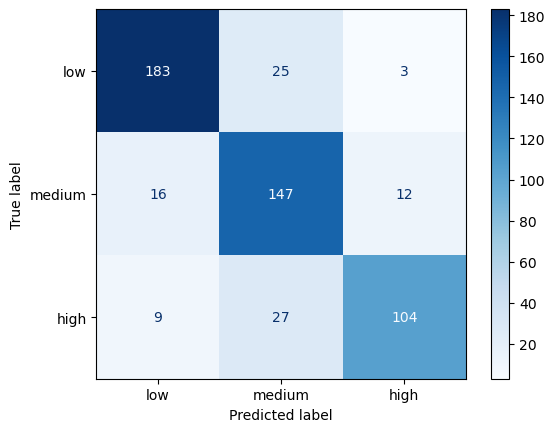

In [24]:
# Confusion matrix
cm = confusion_matrix(y_true_indices, pred_indices)
print(cm)
print()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [25]:
size_mb = os.path.getsize("basic-cnn.h5") / (1024 * 1024)
print(f"Model weights size: {size_mb:.2f} MB")

Model weights size: 3.58 MB
